## Dataset Reference

This study uses the following publicly available dataset:

Rahman, Tabassum Yesmin (2019). *A histopathological image repository of normal epithelium of Oral Cavity and Oral Squamous Cell Carcinoma*.  
Mendeley Data, Version 1.  
DOI: https://doi.org/10.17632/ftmp4cvtmb.1


Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Environment Setup

In [1]:
!apt-get install -y graphviz
!pip install pydot graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


GPU Check

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

Dataset Path & Parameters

In [4]:
DATASET_PATH = "/content/drive/MyDrive/First_Set"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 40
NUM_CLASSES = 2

Data Generators

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 424 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
Found 528 images belonging to 2 classes.


Class Labels

In [6]:
class_labels = list(train_generator.class_indices.keys())
class_labels

['100x_Normal_Oral_Cavity_Histopathological_Images',
 '100x_OSCC_Histopathological_Images']

Define Custom CNN Model

In [7]:
model = Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile Model

In [8]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,860,930 (37.62 MB)

 Trainable params: 9,859,970 (37.61 MB)

 Non-trainable params: 960 (3.75 KB)

Callbacks

In [9]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/oral_cancer_cnn_best.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

Train CNN Model

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 525s 19s/step - accuracy: 0.7325 - loss: 1.2431 - val_accuracy: 0.1635 - val_loss: 2.2516
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7815 - loss: 0.9436 - val_accuracy: 0.1635 - val_loss: 2.8693
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7519 - loss: 0.9164 - val_accuracy: 0.3077 - val_loss: 0.7321
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8049 - loss: 0.7229 - val_accuracy: 0.8365 - val_loss: 0.4750
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7961 - loss: 0.7136 - val_accuracy: 0.8365 - val_loss: 0.5145
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8505 - loss: 0.5090 - val_accuracy: 0.8365 - val_loss: 0.4981
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8260 - loss: 0.5819 - val_accuracy: 0.8365 - val_loss: 1.6897
Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7965 - loss: 0.6512 - val_accuracy: 0.8365 - val_los

Training Curves

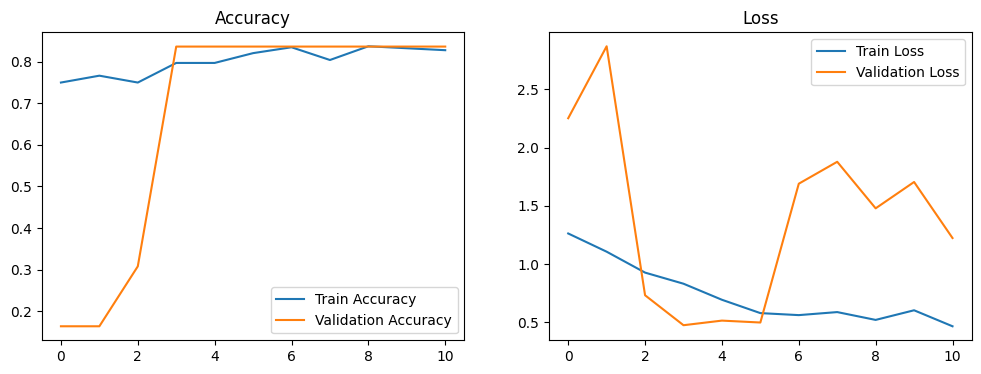

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()

Evaluation Utility

In [12]:
def evaluate_model(generator, model):
    generator.reset()
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "F1-score": f1_score(y_true, y_pred, average="weighted")
    }

Train / Val / Test Metrics

In [13]:
train_metrics = evaluate_model(train_generator, model)
val_metrics = evaluate_model(val_generator, model)
test_metrics = evaluate_model(test_generator, model)

metrics_df = pd.DataFrame.from_dict(
    {
        "Training": train_metrics,
        "Validation": val_metrics,
        "Test": test_metrics
    },
    orient="index"
)

metrics_df

27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 954ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,Precision,Recall,F1-score
Training,0.830189,0.689213,0.830189,0.753161
Validation,0.836538,0.699797,0.836538,0.762082
Test,0.831439,0.691291,0.831439,0.754916


Classification Report (Test Set)

In [14]:
test_generator.reset()
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print(classification_report(y_true, y_pred, target_names=class_labels))

33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 923ms/step
                                                  precision    recall  f1-score   support

100x_Normal_Oral_Cavity_Histopathological_Images       0.00      0.00      0.00        89
              100x_OSCC_Histopathological_Images       0.83      1.00      0.91       439

                                        accuracy                           0.83       528
                                       macro avg       0.42      0.50      0.45       528
                                    weighted avg       0.69      0.83      0.75       528



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Load the trained model

In [2]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/drive/MyDrive/oral_cancer_cnn_best.keras"
)

MODEL ARCHITECTURE VISUALIZATION

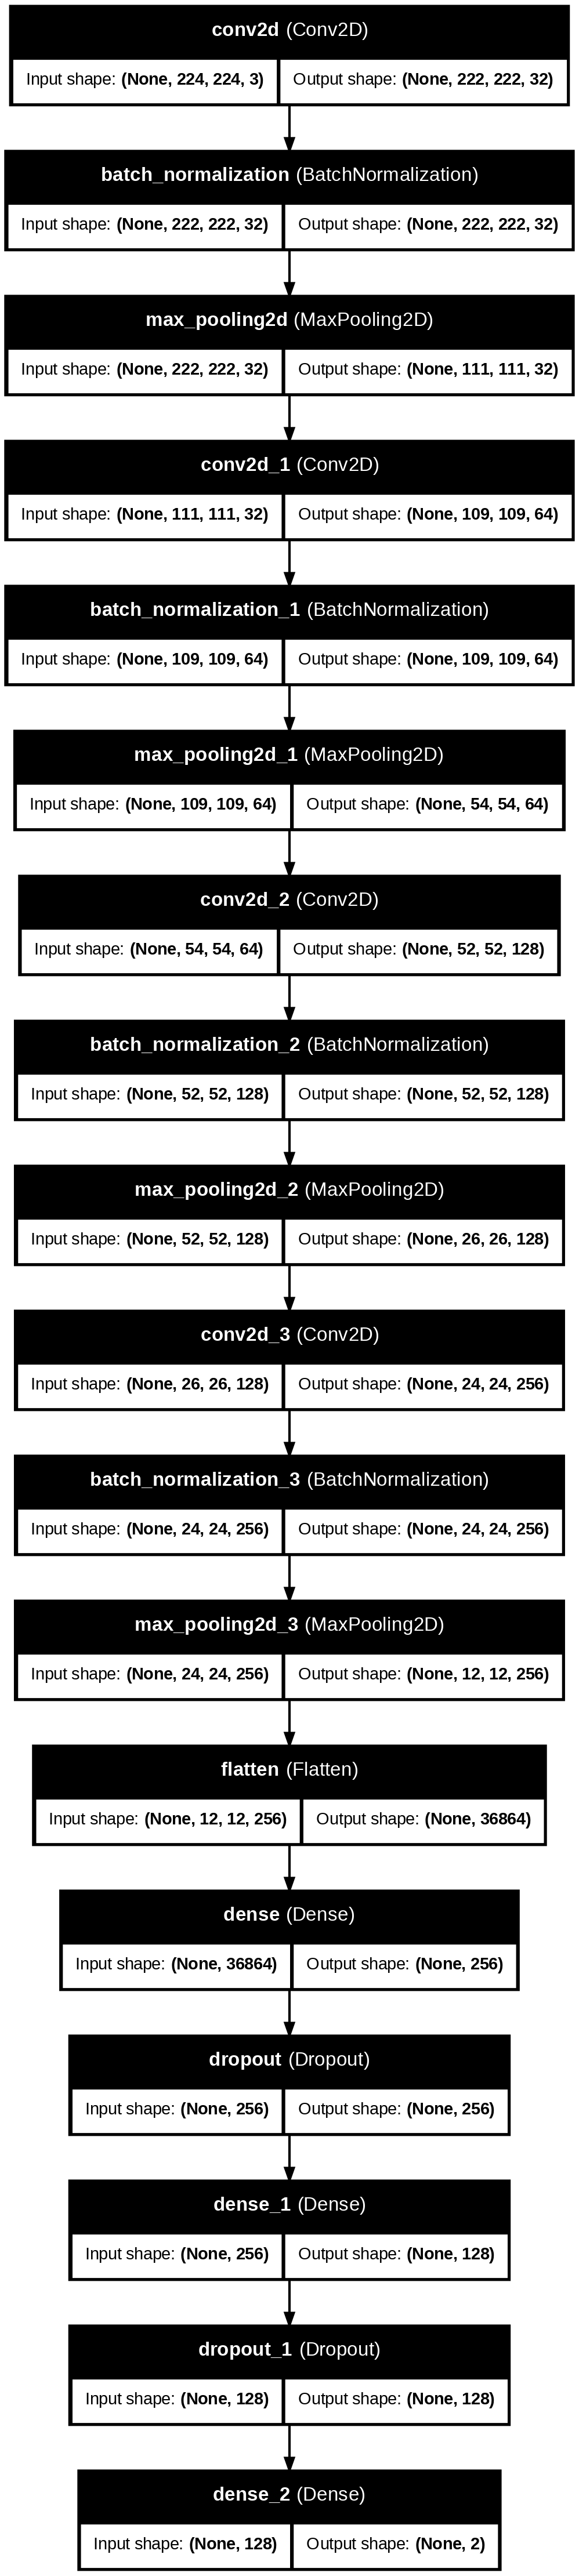

In [3]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="/content/drive/MyDrive/CNN_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=150
)